In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

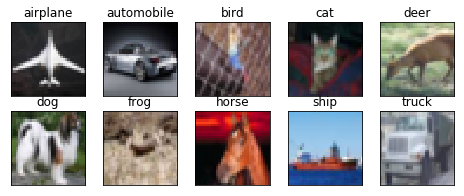

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
from keras.layers.advanced_activations import ReLU
from keras.layers import Concatenate,Input,Conv2D,SeparableConv2D
from keras.models import Model

input = Input(shape=(32, 32, 3,))

# Layer 1
# Receptive field - 3
layer_1 = Conv2D(32, (3,3), strides=(1,1), border_mode='same')(input)
layer_1 = BatchNormalization()(layer_1)
layer_1 = ReLU()(layer_1)


# Spatially seperable convolution
# Layer 2
# Receptive field - 5
# 3 * 1
layer_2 = Conv2D(32, (3,1), strides=(1,1), border_mode='same')(layer_1)
layer_2 = BatchNormalization()(layer_2)
layer_2 = ReLU()(layer_2)

# Spatially seperable convolution
# Layer 3
# Receptive field - 5
# 1 * 3
layer_3 = Conv2D(64, (1,3), strides=(1,1), border_mode='same')(layer_2)
layer_3 = BatchNormalization()(layer_3)
layer_3 = ReLU()(layer_3)


# Layer 4
# Receptive field - 10
layer_4 = MaxPooling2D(pool_size=(2, 2))(layer_3)
layer_4 = BatchNormalization()(layer_4)
layer_4 = Dropout(0.25)(layer_4)



# Depthwise seperable convolution
# Layer 5
# Receptive field - 12
layer_5 = SeparableConv2D(128, (3,3), strides=(1,1), border_mode='same')(layer_4)
layer_5 = BatchNormalization()(layer_5)
layer_5 = ReLU()(layer_5)



# Grouped Convolution (3 * 3)
# Layer 6
# Receptive field - 14
layer_6 = Conv2D(128, (3,3), strides=(1,1), border_mode='same')(layer_5)
layer_6 = BatchNormalization()(layer_6)
layer_6 = ReLU()(layer_6)



# Grouped Convolution (5 * 5)
# Layer 7
# Receptive field - 16
layer_7 = Conv2D(128, (3,3), strides=(1,1), border_mode='same')(layer_6)
layer_7 = BatchNormalization()(layer_7)
layer_7 = ReLU()(layer_7)



# Concatenate grouped convolved layers
layer_7_concatenate = Concatenate(name='conv_merge')([layer_6, layer_7])


# Layer 8
# Receptive field - 28
layer_8 = MaxPooling2D(pool_size=(2, 2))(layer_7_concatenate)
layer_8 = Conv2D(32, (1,1), strides=(1,1), border_mode='same')(layer_8)
layer_8 = BatchNormalization()(layer_8)
layer_8 = Dropout(0.25)(layer_8)



# Grouped Convolution (3 * 3) and dilation = 1
# Layer 9
# Receptive field - 30
layer_9 = Conv2D(32, (3,3), strides=(1,1), border_mode='same',dilation_rate=(1,1))(layer_8)
layer_9 = BatchNormalization()(layer_9)
layer_9 = ReLU()(layer_9)


# Grouped Convolution (3 * 3) and dilation = 2
# Layer 10
# Receptive field - 32
layer_10 = Conv2D(32, (3,3), strides=(1,1), border_mode='same',dilation_rate=(2,2))(layer_8)
layer_10 = BatchNormalization()(layer_10)
layer_10 = ReLU()(layer_10)


# Concatenate grouped convolved layers
layer_10_concatenate = Concatenate(name='conv_merge_1')([layer_9, layer_10])



# Layer 11
# Receptive field - 32
layer_11 = Conv2D(64, (3,3), border_mode='same')(layer_10_concatenate)
layer_11 = BatchNormalization()(layer_11)
layer_11 = ReLU()(layer_11)

# Layer 12
layer_12 = Conv2D(10, (1,1), border_mode='same')(layer_11)
layer_12 = BatchNormalization()(layer_12)
layer_12 = ReLU()(layer_12)
layer_12 = Conv2D(10, (8,8))(layer_12)


# Layer 23
layer_13 = Flatten()(layer_12)
output = Activation('softmax')(layer_13)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: Us

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 32)   128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
re_lu_11 (ReLU)                 (None, 32, 32, 32)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_13 

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 37s 95ms/step - loss: 1.3501 - acc: 0.5085 - val_loss: 1.2434 - val_acc: 0.5506
Epoch 2/50
390/390 [==============================] - 30s 78ms/step - loss: 0.9314 - acc: 0.6672 - val_loss: 0.9393 - val_acc: 0.6745
Epoch 3/50
390/390 [==============================] - 30s 77ms/step - loss: 0.7562 - acc: 0.7338 - val_loss: 0.8898 - val_acc: 0.6983
Epoch 4/50
390/390 [==============================] - 30s 77ms/step - loss: 0.6682 - acc: 0.7650 - val_loss: 0.8191 - val_acc: 0.7316
Epoch 5/50
390/390 [==============================] - 30s 77ms/step - loss: 0.5993 - acc: 0.7901 - val_loss: 0.7341 - val_acc: 0.7499
Epoch 6/50
390/390 [==============================] - 30s 76ms/step - loss: 0.5414 - acc: 0.8117 - val_loss: 0.7150 - val_acc: 0.7623
Epoch 7/50
390/390 [==============================] - 30s 76ms/step - loss: 0.4995 - acc: 0.8248 - val_loss: 0.7389 - val_acc: 0.7605
Epoch 8/50
390/390 [==============================] - 30s 76ms

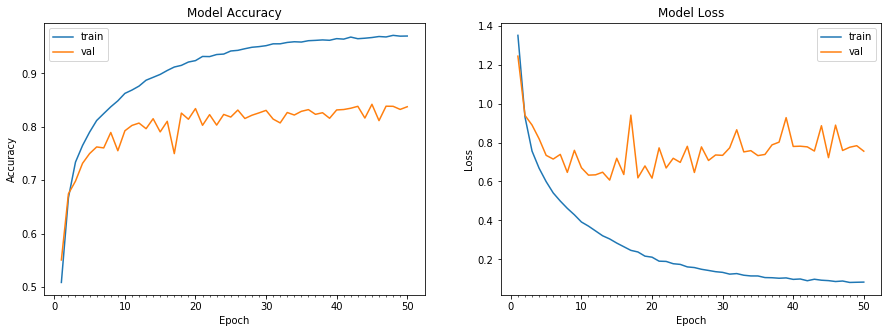

Accuracy on test data is: 83.76


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))